In [1]:
import numpy as np
import math
import random
import scipy as sp
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import cm
from scipy import interpolate

from Pricing_tools import ModelClasses
from Pricing_tools import OptionClasses
from Pricing_tools import Pricers

In this notebook, we use the Monte-Carlo pricers from the Pricers class to plot simulated Call prices and Down-and-out call (DOC) prices, using the Heston model for some arbitrarily chosen parameters. The prices are plotted in 2D grid $(strike,maturity)$ for the call prices (with fixed $S_0$), and for a grid $(strike,S_0)$ for the DOC prices in order to illustrate the influence of the barrier $L$.

Call $C(S_0,T,K)$ prices have payoff $(S_T-K)_+$, whereas DOC prices $DOC(S_0,T,K,L)$ prices have payoff $(S_T-K)_+1_{\{min_{t\leq T}S_t\leq L\}}$.

Since the (strong) rate of convergence of the Euler scheme is only $O(\sqrt{h})$ ($h$ discretization schemes), the speed of convergence to the option prices is poor for the DOC option. To recover a $O(h)$ rate of convergence, we implement the methodology described in https://www2.maths.ox.ac.uk/~gilesm/mc/module_4/module_4_1.pdf in the class DOC_Optimized.

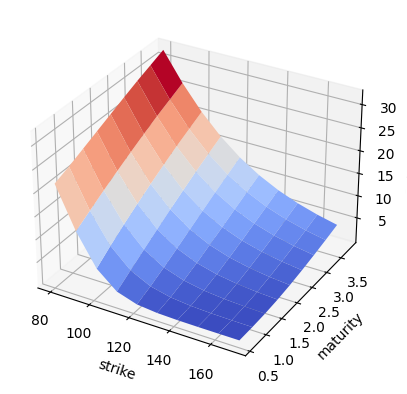

In [7]:
# First, we plot the call prices
# Choice of parameters
    
    
N       = 100000
steps   = 1000
S0      = 100
r       = 0.03
sigma   = 0.235
vb      = 0.06
v0      = 0.02
kappa   = 0.6
epsilon = 0.2
rho     = -0.5

#Plotting the call prices for Heston, Black-Scholes as well as the implicit volatility surface

fig  = plt.figure()
ax   = fig.add_subplot(111, projection='3d')

model    = ModelClasses.HestonModel(r, kappa, v0, vb, epsilon, rho, S0)
strikes  = np.array([80,90,100,110,120,130,140,150,160,170])
mat      = np.array([0.6,1,1.4,1.8,2.2,2.6,3,3.4,3.8])
options  = np.array([[OptionClasses.Call(strike,time) for time in mat] for strike in strikes])
prices   = Pricers.MonteCarloPricer(model, options, steps, N)


Strikes, Mat = np.meshgrid(strikes, mat)


ax.plot_surface(Strikes, Mat, prices.transpose(), cmap=cm.coolwarm, antialiased=True)

ax.set_xlabel('strike')
ax.set_ylabel('maturity')
ax.set_zlabel('Call prices')

plt.show()

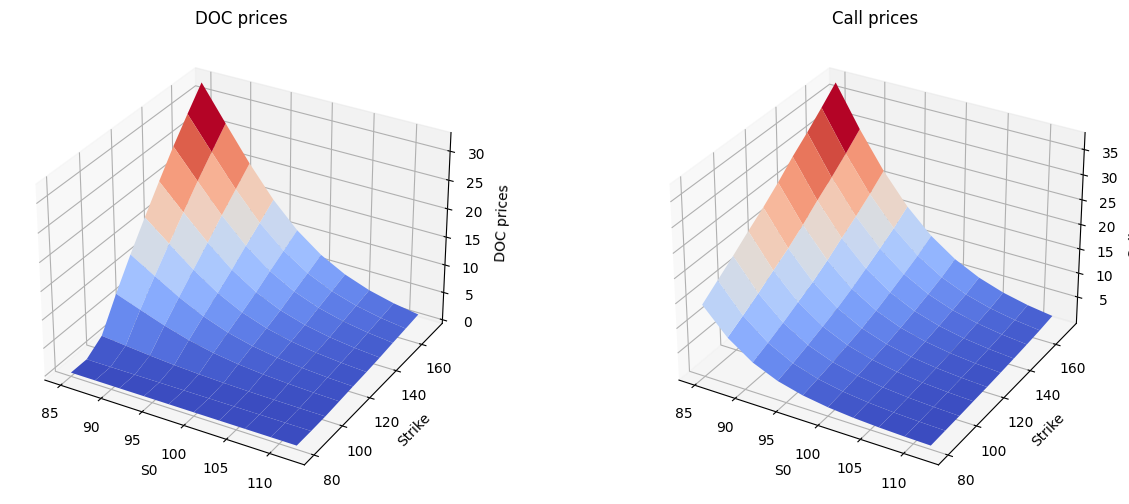

In [6]:
#Next, we plot the DOC prices, which we compare to the call prices (fixed maturity and barrier)

N       = 100000
steps   = 1000
mat     = 2
r       = 0.03
sigma   = 0.235
vb      = 0.06
v0      = 0.02
kappa   = 0.6
epsilon = 0.2
rho     = -0.5

#Plotting the DOC prices for Heston, Black-Scholes as well as the implicit volatility surface

L = 90

fig   = plt.figure(figsize=(15,6))
ax1   = fig.add_subplot(121, projection='3d')


strikes   = np.array([80,90,100,110,120,130,140,150,160,170])
S0        = np.array([85,88,91,94,97,100,103,106,109,112])
models    = np.array([ModelClasses.HestonModel(r, kappa, v0, vb, epsilon, rho, s0) for s0 in S0])
options1  = np.array([OptionClasses.DOCOptimized(strike, L, mat) for strike in strikes])
prices1   = np.array([[Pricers.MonteCarloPricer(model, options1, steps, N)]
                     for model in models]).reshape((len(models),len(options1)))
                    

S_in, Strikes = np.meshgrid(S0, strikes)


ax1.plot_surface(S_in, Strikes, prices1, cmap=cm.coolwarm, antialiased=True)

ax1.set_xlabel('S0')
ax1.set_ylabel('Strike')
ax1.set_zlabel('DOC prices')
ax1.title.set_text('DOC prices')

options2  = np.array([OptionClasses.Call(strike, mat) for strike in strikes])
prices2   = np.array([[Pricers.MonteCarloPricer(model, options2, steps, N)]
                     for model in models]).reshape((len(models),len(options2)))


ax2   = fig.add_subplot(122, projection='3d')
ax2.plot_surface(S_in, Strikes, prices2, cmap=cm.coolwarm, antialiased=True)

ax2.set_xlabel('S0')
ax2.set_ylabel('Strike')
ax2.set_zlabel('Call prices')
ax2.title.set_text('Call prices')

plt.show()